<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# News Article Classification


Today, you are a machine learning engineer at [Upday](https://www.upday.com/home), a news app. The engine behind the app processes almost 100k news articles every day in many languages and context. In order to connect people with the right content, we need to know what the articles are about. 

The job here is to build a classifier that identify the category of an article accurately that will be fed into the recommendation algorithms of the app for better personalized content for the readers. 

You will first train a Transformer from scratch; then fine-tune a pre-trained Transformer model for text classification using 🤗; and compare performances using the same test data set.

## Learning objectives


By the end of this session, you will be able to:
- Understand how Transformer models work
- Build a Transformer model for text classification from scratch
- Fine-tune a pre-trained Transformer model for text classification using 🤗 

# Task 1. Prepare the data

1. [20 news groups data](http://qwone.com/~jason/20Newsgroups/) is one of the standard datasets in the `scikit-learn`. The 20 newsgroups dataset comprises around 18k newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the two datasets is based upon messages posted before and after a specific date.

    Take a read on its [usage](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset) and load the training and testing datasets into `train` and `test` respectively via `fetch_20newsgroups`.

In [1]:
!nvidia-smi

Wed Nov  2 02:02:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    45W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
NUM_LABELS = 20

In [3]:
from sklearn.datasets import fetch_20newsgroups

train = fetch_20newsgroups(subset='train')
test = fetch_20newsgroups(subset='test')

# check data types:
print(f'Type and length of train: {type(train)} \t{len(train)}')
print(f'Type and length of test : {type(test)} \t{len(test)}\n')

# explore class sklearn.utils.Bunch:
print(f'\tType and length of train["data"]:  \t\t{type(train["data"])} '
          f'\t{len(train["data"]):5d}\n' 
      f'\tType and length of train["target_names"]: \t{type(train["target_names"])} '
          f'\t{len(train["target_names"]):5d}\n'
      f'\tType and shape of train["target"]:     {type(train["target"])} '
          f'\t{train["target"].shape}\n\n'

      f'\tType and length of test["data"]:  \t\t{type(test["data"])} '
          f'\t{len(test["data"]):5d}\n' 
      f'\tType and length of test["target_names"]: \t{type(test["target_names"])} '
          f'\t{len(test["target_names"]):5d}\n'
      f'\tType and shape of test["target"]:      {type(test["target"])} '
          f'\t{test["target"].shape}\n\n')

# take a look at keys in train data set:
print(f'train.keys data type: \t{type(train.keys())}\n'
      f'train keys:           \t{train.keys()}\n')

# what is in train['target_names']?
print('train["target_names"] contents:', *train["target_names"], sep='\n\t')

Type and length of train: <class 'sklearn.utils.Bunch'> 	5
Type and length of test : <class 'sklearn.utils.Bunch'> 	5

	Type and length of train["data"]:  		<class 'list'> 	11314
	Type and length of train["target_names"]: 	<class 'list'> 	   20
	Type and shape of train["target"]:     <class 'numpy.ndarray'> 	(11314,)

	Type and length of test["data"]:  		<class 'list'> 	 7532
	Type and length of test["target_names"]: 	<class 'list'> 	   20
	Type and shape of test["target"]:      <class 'numpy.ndarray'> 	(7532,)


train.keys data type: 	<class 'dict_keys'>
train keys:           	dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

train["target_names"] contents:
	alt.atheism
	comp.graphics
	comp.os.ms-windows.misc
	comp.sys.ibm.pc.hardware
	comp.sys.mac.hardware
	comp.windows.x
	misc.forsale
	rec.autos
	rec.motorcycles
	rec.sport.baseball
	rec.sport.hockey
	sci.crypt
	sci.electronics
	sci.med
	sci.space
	soc.religion.christian
	talk.politics.guns
	talk.politics.mideast
	

1. Explore the data. For example, what is the data type of `train` and `test`? What is the data type of `train['data']`? What is in `train['target_names']`? 

    ___Answer:___  
    *  _See above cell output; also:_  
      
    * `train["data"]` is a list of the texts ('documents') in this data set.  
      
    * `train["target_names"]` is a `list` object containing the data set's 20 topics ('categories').  
      
    * `train["target"]` is an `ndarray` containing the assigned (ground-truth) category labels for the texts in `train["data"]`. (Each of the 20 categories in `train["target_names"]` has been assigned a numerical value from 0-19, inclusive).
         
    * ___NB:___ __`class sklearn.utils.Bunch`__ is a __container object__ exposing keys as attributes, and allows dictionary values to be accessed via keys or attribute, e.g., `bunch["value_key"]` or `bunch.value_key`.  
      
    * The __20 Newsgroups data set__ documentation describes the set as partitioned about evenly across 20 different 'newsgroups' (= 'topics' = 'categories' = `target_names`). It groups these topics/categories by __subject-matter relatedness__ as follows (see: http://qwone.com/~jason/20Newsgroups/):

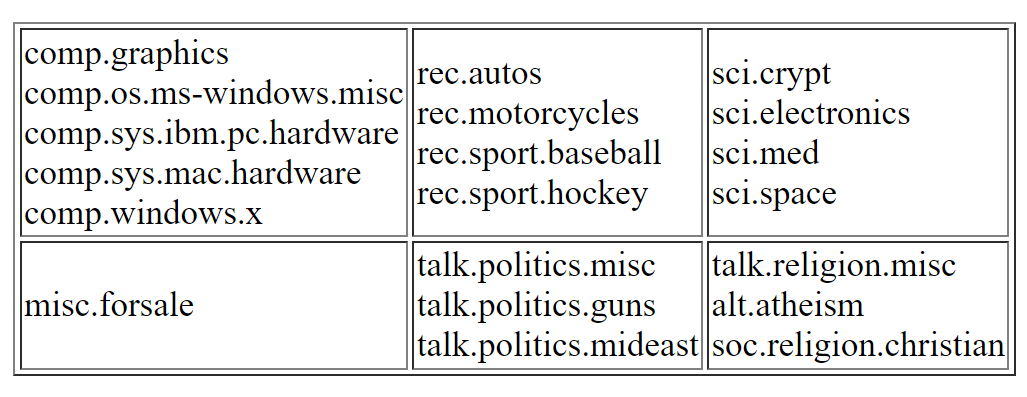

1. Train / validation / test splits. 

    There are ~~four~~ __five__ keys in each data set and we need "data" (the text) and "target" (the category). Extract the "data" and create a `pd.Series` named `X`; and extract the "target" and create a `pd.Series` named `y`. Do the same for the `test` data set, named `X_test` and `y_test`, respectively.  

In [4]:
import pandas as pd
# set pandas max column width to n:
pd.options.display.max_colwidth = 256

X, y = pd.Series(train['data']), pd.Series(train['target'])
X_test, y_test = pd.Series(test['data']), pd.Series(test['target'])

# take a look at the series:
display(X, y, X_test, y_test)

0        From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nt...
1        From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 1...
2        From: twillis@ec.ecn.purdue.edu (Thomas E Willis)\nSubject: PB questions...\nOrganization: Purdue University Engineering Computer Network\nDistribution: usa\nLines: 36\n\nwell folks, my mac plus finally gave up the ghost this weekend after\nstarting li...
3        From: jgreen@amber (Joe Green)\nSubject: Re: Weitek P9000 ?\nOrganization: Harris Computer Systems Division\nLines: 14\nDistribution: world\nNNTP-Posting-Host: amber.ssd.csd.harris.com\nX-Newsread

0         7
1         4
2         4
3         1
4        14
         ..
11309    13
11310     4
11311     3
11312     1
11313     8
Length: 11314, dtype: int64

0       From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. GANDLER)\nSubject: Need info on 88-89 Bonneville\nOrganization: University at Buffalo\nLines: 10\nNews-Software: VAX/VMS VNEWS 1.41\nNntp-Posting-Host: ubvmsd.cc.buffalo.edu\n\n\n I am a little confused on ...
1       From: Rick Miller <rick@ee.uwm.edu>\nSubject: X-Face?\nOrganization: Just me.\nLines: 17\nDistribution: world\nNNTP-Posting-Host: 129.89.2.33\nSummary: Go ahead... swamp me.  <EEP!>\n\nI'm not familiar at all with the format of these "X-Face:" thingies...
2       From: mathew <mathew@mantis.co.uk>\nSubject: Re: STRONG & weak Atheism\nOrganization: Mantis Consultants, Cambridge. UK.\nX-Newsreader: rusnews v1.02\nLines: 9\n\nacooper@mac.cc.macalstr.edu (Turin Turambar, ME Department of Utter Misery) writes:\n> Di...
3       From: bakken@cs.arizona.edu (Dave Bakken)\nSubject: Re: Saudi clergy condemns debut of human rights group!\nKeywords: international, non-usa government, government, civil rights, \tsocial issues, poli

0        7
1        5
2        0
3       17
4       19
        ..
7527    14
7528     4
7529     9
7530     6
7531    15
Length: 7532, dtype: int64

In [5]:
# let's look at the length (in words) of some of the data texts:

# list of list of each text split into individual words:
data_split = [x.split() for x in X[:21]]

# count no. of words in each list:
data_split_len = [len(y) for y in data_split]

# view results:
print(*data_split, sep='\n')
print('\n\n')
print(*data_split_len, sep=',  ')

['From:', 'lerxst@wam.umd.edu', "(where's", 'my', 'thing)', 'Subject:', 'WHAT', 'car', 'is', 'this!?', 'Nntp-Posting-Host:', 'rac3.wam.umd.edu', 'Organization:', 'University', 'of', 'Maryland,', 'College', 'Park', 'Lines:', '15', 'I', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'I', 'saw', 'the', 'other', 'day.', 'It', 'was', 'a', '2-door', 'sports', 'car,', 'looked', 'to', 'be', 'from', 'the', 'late', '60s/', 'early', '70s.', 'It', 'was', 'called', 'a', 'Bricklin.', 'The', 'doors', 'were', 'really', 'small.', 'In', 'addition,', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body.', 'This', 'is', 'all', 'I', 'know.', 'If', 'anyone', 'can', 'tellme', 'a', 'model', 'name,', 'engine', 'specs,', 'years', 'of', 'production,', 'where', 'this', 'car', 'is', 'made,', 'history,', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car,', 'please', 'e-mail.', 'Thanks,', '-', 'IL', 

Now split `X` and `y` into training and validation sets. Use `train_test_split` from `sklearn.model_selection` to split the data; save 10% of the data for validation and set the random state to 19.

In [6]:
from sklearn.model_selection import train_test_split 

# stratify by labels in y to ensure class balance
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.10, random_state=19, stratify=y)

In [7]:
assert y_train.shape == (10182,)
assert y_valid.shape == (1132,)
assert y_test.shape == (7532,)

1. Convert categorical labels into dummy variables. 

    Use `pd.get_dummies` to convert labels into dummy variables for `y_train`, `y_valid`, `y_test`.

In [8]:
y_train = pd.get_dummies(y_train)
y_valid = pd.get_dummies(y_valid)
y_test =  pd.get_dummies(y_test)

In [9]:
assert y_train.shape == (10182, NUM_LABELS)
assert y_valid.shape == (1132, NUM_LABELS)
assert y_test.shape == (7532, NUM_LABELS)

In [10]:
# take a quick look
display(y_train.head(5))
display(y_valid.head(5))
display(y_test.head(5))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
3597,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
280,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7182,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2235,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5830,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1274,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9085,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
10994,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11068,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4164,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1



# Task 2. Attention is all you need

Recently most of the natural language processing tasks are being dominated by the `Transformer` architecture, introduced in [Attention Is All You Need](https://arxiv.org/abs/1706.03762), which used a simple mechanism called `Neural Attention` as one of its building blocks. As the title suggests this architecture didn't require any recurrent layer. We now build a text classification using Attention and Positional Embeddings.

1. Transformer (attention) Block. 

    The concept of `Neural Attention` is fairly simple; i.e., not all input information seen by a model is equally important to the task at hand. Although this concept has been utilized at various different places as well, e.g., max pooling in ConvNets, but the kind of attention we are looking for should be `context aware`.

    The attention mechanism allows output to focus attention on input while producing output while the self-attention model allows inputs to interact with each other; in other words, calculate attention of all other inputs with respect to one input.

    In the paper, the authors proposed another type of attention mechanism called multi-headed attention which refers to the fact that the outer space of the self attention layer gets factored into a set of independent sub-spaces learned separately, where each subspace is called a "head". **You need to implement the multi-head attention layer**, supplying values for two parameters: `num_heads` and `key_dim`.

    There is a learnable dense projection present after the multi-head attention which enables the layer to actually learn something, as opposed to being a purely stateless transformation. **You need to implement `dense_proj`**, use the `tf.keras.Sequential` to stack two dense layers: 
    
        1. first dense layer with `dense_dim` units and activation function `relu`;
        2. second dense layer with `embed_dim` units and no activation function.

In [11]:
from tensorflow.keras import layers as L
import tensorflow as tf
from tensorflow import keras

# implement TransformerBlock layer using call() method
# NB: encoder = multi-head self-attention → 'layernorm1' (on residual connection
#     from 'inputs' + mha output) → positionwise fully connected ffn = learnable
#     'dense_proj' (keras sequential dense layers) → 'layernorm2' (on residual 
#     connection with 'layernorm1' + ffn 'dense_proj' output)
# 
# NB: this implementation doesn't apply dropout in 'MultiHeadAttention'nor on
#     output of ffn 'dense_proj' (during training):

class TransformerBlock(L.Layer):
    # __init__ creates all layers accessed by call method
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # implement multi-head attention layer:
        self.attention = L.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )

        # implement dense_proj (learnable):
        self.dense_proj = tf.keras.Sequential(
            [
                L.Dense(dense_dim, activation='relu', name='layer1_ffn'),
                L.Dense(embed_dim, name='layer2_ffn'),
            ]
        )
        self.layernorm1 = L.LayerNormalization()
        self.layernorm2 = L.LayerNormalization()
        super().__init__(**kwargs)
    
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[: tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm2(proj_input + proj_output)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim
        })
        return config

1. Positional embedding. 

    The idea behind Positional Encoding is fairly simple as well: to give the model access to token order information, therefore we are going to add the token's position in the sentence to each word embedding.

    Thus, __one input word embedding will have two components: the usual token vector representing the token independent of any specific context, and a position vector representing the position of the token in the current sequence.__  

In [12]:
class PositionalEmbedding(L.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):

        # NB: input_dim = vocab size
        #     output_dim = dim of dense embedding
        self.token_embeddings = L.Embedding(input_dim, output_dim)
        self.position_embeddings = L.Embedding(sequence_length, output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        super().__init__(**kwargs)
        
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)

        # NB: returns token vector + position vector
        return embedded_tokens + embedded_positions
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

1. Define some constants to parameterize the model.

In [13]:
VOCAB_SIZE = 10_000
EMBED_DIM = 256
DENSE_DIM = 32
NUM_HEADS = 2
MAX_LEN = 256

1. Tokenizer. 
    
    The tokenizer is a simple tool to convert a text into a sequence of tokens. It is used to convert the training data into a sequence of integers, which are then used as input to the model. 

    Use `Tokenizer` to create a tokenizer for the training data. Set the `num_words` parameter to the number of words to keep in the vocabulary, and `oov_token` to be `"<unk>"`.

In [14]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(
    num_words=VOCAB_SIZE,
    oov_token='<unk>'
)
tokenizer.fit_on_texts(X_train)

# store a word index for our training data X_train:
word_index = tokenizer.word_index

1. Pad the sequences. 
    
    The tokenizer outputs a sequence of integers, which are then used as input to the model. However, the model expects a sequence of fixed length. To pad the sequences to the same length, use `sequence.pad_sequences` from `keras.preprocessing`.

    Complete function `preprocess` below to 1) tokenize the texts 2) pad the sequences to the same length.

*  NB: We are arbitrarily using a max sequence length of 256 words, although it is clear from the examples above, that some texts have many more words!  
  
*  NB: In processing texts to `MAX_LEN` using padding/truncation, note that the default behavior of `tf.keras.utils.pad_sequences` is to do 'pre' padding and 'pre' truncation with a default value of '0'.  
  
*  The default pre-padding likely mitigates the adverse effects of lengthy sequences in traditional RNNs, which should not apply to transformers. (We can come back and test this by e.g., setting `padding='post'` and `truncating='post'` in code below:)

In [15]:
# deprecated:
from keras.preprocessing import sequence

def preprocess(texts, tokenizer, maxlen:int = MAX_LEN):

    # tokenize:
    seqs = tokenizer.texts_to_sequences(texts)

    # (don't use deprecated sequence.pad_sequences)
    tokenized_text = tf.keras.utils.pad_sequences(
        sequences=seqs,
        maxlen=MAX_LEN,
        padding='pre',
        truncating='pre'
    )                                                 
    return tokenized_text

1. Preprocess the data. 
    
    Use `preprocess` to preprocess the training, validation, and test data.

In [16]:
X_train = preprocess(texts=X_train, tokenizer=tokenizer, maxlen=MAX_LEN)
X_valid = preprocess(texts=X_valid, tokenizer=tokenizer, maxlen=MAX_LEN)
X_test  = preprocess(texts=X_test,  tokenizer=tokenizer, maxlen=MAX_LEN)

In [17]:
# check output of preprocessing:
X_train.shape, X_valid.shape, X_test.shape

((10182, 256), (1132, 256), (7532, 256))

1. Define the model with the following architecture: 

    * Input Layer
    * Positional Embeddings
    * Transformer Block
    * Pooling
    * Dropout
    * Output Layer

    If you are not familiar with keras functional API, take a read [here](https://keras.io/guides/functional_api/).

In [18]:
inputs = keras.Input(shape=(None, ), dtype="int64")

x = PositionalEmbedding(sequence_length=MAX_LEN,
                        input_dim=VOCAB_SIZE,
                        output_dim=EMBED_DIM)(inputs)

x = TransformerBlock(embed_dim=EMBED_DIM,
                     dense_dim=DENSE_DIM,
                     num_heads=NUM_HEADS)(x)
                     
x = L.GlobalMaxPooling1D()(x)
x = L.Dropout(0.5)(x)
outputs = L.Dense(20, activation='softmax')(x)

model = keras.Model(inputs, outputs)

1. Compile model. 

    Use 'adam' for the optimizer and accuracy for metrics, supply the correct value for loss. 

In [19]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posit  (None, None, 256)        2625536   
 ionalEmbedding)                                                 
                                                                 
 transformer_block (Transfor  (None, None, 256)        543776    
 merBlock)                                                       
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

1. Add [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) and [ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/) to stop training if the model does not improve a set metric after a given number of epochs. 

    Create an `EarlyStopping` object named `es` to stop training if the validation loss does not improve after 5 epochs. Set verbose to display messages when the callback takes an action and set `restore_best_weights` to restore model weights from the epoch with the best value of the monitored metric.
    
    Use `ReduceLROnPlateau` to reduce the learning rate if the validation loss does not improve after 3 epochs. Set verbose to display messages when the callback takes an action and use default values for other parameters.
    

In [21]:
# early stopping:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    restore_best_weights=True
)
# reduce learning rate when metric stops improving:
rlp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.333,
    patience=3,
    verbose=1,
    min_delta=0.0001,
    min_lr=0.0000001
)

1. Train the model. 
    
    Supply both `EarlyStopping` and `ReduceLROnPlateau` for `callbacks`. Set `epochs` to 100.

In [22]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_valid, y_valid),
    callbacks= [es, rlp],
    epochs=100,
)

Epoch 1/100
319/319 [==============================] - 10s 9ms/step - loss: 3.1070 - accuracy: 0.1827 - val_loss: 1.1981 - val_accuracy: 0.6431 - lr: 0.0010
Epoch 2/100
319/319 [==============================] - 3s 8ms/step - loss: 0.9860 - accuracy: 0.7097 - val_loss: 0.6637 - val_accuracy: 0.8127 - lr: 0.0010
Epoch 3/100
319/319 [==============================] - 2s 8ms/step - loss: 0.4168 - accuracy: 0.8744 - val_loss: 0.5448 - val_accuracy: 0.8472 - lr: 0.0010
Epoch 4/100
319/319 [==============================] - 2s 8ms/step - loss: 0.1536 - accuracy: 0.9531 - val_loss: 0.5840 - val_accuracy: 0.8525 - lr: 0.0010
Epoch 5/100
319/319 [==============================] - 2s 8ms/step - loss: 0.0652 - accuracy: 0.9832 - val_loss: 0.6670 - val_accuracy: 0.8551 - lr: 0.0010
Epoch 6/100
316/319 [============================>.] - ETA: 0s - loss: 0.0385 - accuracy: 0.9907
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003330000158166513.
319/319 [==============================] - 2s 

1. Evaluate the trained model on the test data. 
    
    Use `evaluate` to evaluate the model on the test data (accuracy will be around 0.77).

In [23]:
# YOUR CODE HERE
# Looking at keras metrics on X_test using model.evaluate:

results = model.evaluate(X_test, y_test, verbose='auto')
print(f'Model loss & test accuracy after training with early stopping: {results}\n')

236/236 [==============================] - 1s 4ms/step - loss: 0.8808 - accuracy: 0.7568
Model loss & test accuracy after training with early stopping: [0.8808262944221497, 0.7567710876464844]



1. Visualize both loss and accuracy curves for the training and validation data. 

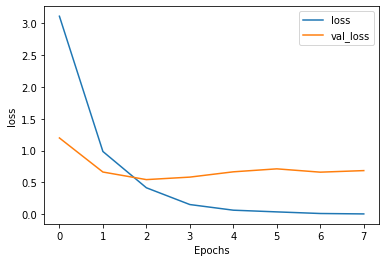

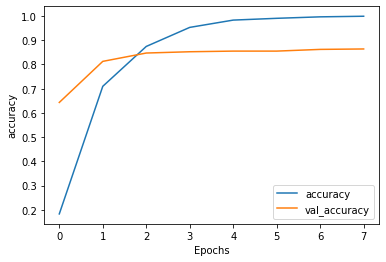

In [24]:
# let's look at above metrics graphically:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  fig, ax = plt.subplots()
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plot_graphs(history,'loss')
plot_graphs(history,'accuracy')

# Task 3. Fine-tune pre-trained model via 🤗

Substantial gains can be achieved by pre-training on a large corpus of text followed by fine-tuning a specific task. In this task, we will take advantage of [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/pdf/1910.01108.pdf), [`distillbert-uncased`](https://huggingface.co/distilbert-base-uncased) specifically, and fine-tune it on the 20 Newsgroups dataset.

1. Install [`Transformers`](https://huggingface.co/docs/transformers) and [`datasets`](https://huggingface.co/docs/datasets/index).

In [25]:
! pip install -U -q transformers datasets

     |████████████████████████████████| 5.5 MB 7.3 MB/s 
     |████████████████████████████████| 441 kB 69.2 MB/s 
     |████████████████████████████████| 7.6 MB 71.8 MB/s 
     |████████████████████████████████| 163 kB 84.5 MB/s 
     |████████████████████████████████| 212 kB 85.6 MB/s 
     |████████████████████████████████| 95 kB 5.0 MB/s 
     |████████████████████████████████| 115 kB 87.3 MB/s 
     |████████████████████████████████| 127 kB 88.6 MB/s 
     |████████████████████████████████| 115 kB 86.3 MB/s 


In [26]:
# ! pip install -U datasets 'dill<0.3.5'

1. Import the library and check its version.


In [27]:
import transformers
print(transformers.__version__)

4.24.0


1. Create `Dataset` objects for train / validation / test sets that are better compatible with the `Transformers` API.

    You can first create a `pd.DataFrame` with two fields: `text` and `label` with `data` and `target` from `train`. Then, call the `Dataset.from_pandas()` method to create a `Dataset` object and save it to `train_ds`. 

    Do the same for test set. 

In [28]:
# # convert train, test "target" labels, which are rank 1 ndarrays to lists:
# train_tgtl = train['target'].tolist()
# test_tgtl  =  test['target'].tolist()
# 
# # check conversion:
# print(train['target'][:24], '\n', train_tgtl[:24], '\n\t', train['target'].shape,
#       '\t', len(train_tgtl))
# print( test['target'][:24], '\n',  test_tgtl[:24], '\n\t',  test['target'].shape,
#       '\t', len( test_tgtl))

In [29]:
from datasets import Dataset
# train_ds = Dataset.from_pandas(pd.DataFrame(list(zip(train['data'], train_tgtl)),
#                                             columns=['text', 'label'])
#                               )
# test_ds  = Dataset.from_pandas(pd.DataFrame(list(zip( test['data'],  test_tgtl)),
#                                             columns=['text', 'label'])
#                               )

train_ds = Dataset.from_pandas(pd.DataFrame(
                               data={'text':train.data, 'label':train.target}))
test_ds  = Dataset.from_pandas(pd.DataFrame(
                               data={'text':test.data,  'label':test.target }))

1. Cast column `label` as `datasets.features.ClassLabel` object using [`class_encode_column`](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.class_encode_column) for both `train_ds` and `test_ds`.

In [30]:
# check features before casting:
print(train_ds.features, '\n', test_ds.features)

{'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None)} 
 {'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None)}


In [31]:
! pip show dill
! pip show datasets

Name: dill
Version: 0.3.5.1
Summary: serialize all of python
Home-page: https://github.com/uqfoundation/dill
Author: Mike McKerns
Author-email: mmckerns@uqfoundation.org
License: 3-clause BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: 
Required-by: tensorflow-datasets, multiprocess, datasets
Name: datasets
Version: 2.6.1
Summary: HuggingFace community-driven open-source library of datasets
Home-page: https://github.com/huggingface/datasets
Author: HuggingFace Inc.
Author-email: thomas@huggingface.co
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: tqdm, aiohttp, dill, multiprocess, pandas, huggingface-hub, responses, pyyaml, packaging, importlib-metadata, numpy, pyarrow, requests, xxhash, fsspec
Required-by: 


In [32]:
train_ds = train_ds.class_encode_column('label')
test_ds  =  test_ds.class_encode_column('label')

Stringifying the column:   0%|          | 0/12 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/12 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

Stringifying the column:   0%|          | 0/8 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/8 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [33]:
# check features after casting:
print(train_ds.features, '\n', test_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9'], id=None)} 
 {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9'], id=None)}


1. Create the validation set by apply [`train_ds.train_test_split()`](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.train_test_split). Similarly, set the test size to 0.1, and set the random state to 19. Make sure the split is stratified by column `label`. Save the result to `train_dsd` as the result is a DatasetDict object.

    Here's another way to do train / validation / test split: [ref](https://discuss.huggingface.co/t/how-to-split-main-dataset-into-train-dev-test-as-datasetdict/1090/2)

In [34]:
train_dsd = train_ds.train_test_split(test_size=0.1, stratify_by_column='label',
                                      seed=19)

In [35]:
train_dsd

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10182
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1132
    })
})

1. Yet the 'test' set inside `train_dsd` is meant for validation, the following code will rename the test set to validation and add a new DataSet object for the test set.

In [36]:
train_dsd['validation'] = train_dsd['test']
train_dsd['test'] = test_ds

In [37]:
train_dsd

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10182
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7532
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1132
    })
})

1. Load the DistilBERT tokenizer to process the text. 
    
    Use [`AutoTokenizer`](https://huggingface.co/docs/transformers/v4.20.1/en/model_doc/auto#transformers.AutoTokenizer) to load the tokenizer for the given `model_checkpoint`. 

In [ ]:
from transformers import AutoTokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer = # YOUR CODE HERE

1. Create a preprocessing function to tokenize text, truncate and pad sequences to be no longer than DistilBERT’s maximum input length:

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True, max_length=MAX_LEN)

1. Use 🤗 Datasets [map](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.map) function to apply the preprocessing function over the entire dataset. You can speed up the map function by setting `batched=True` to process multiple elements of the dataset at once:

In [ ]:
tokenized_text = # YOUR CODE HERE

In [ ]:
tokenized_text

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10182
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7532
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1132
    })
})

1. Use [DataCollatorWithPadding](https://huggingface.co/docs/transformers/v4.20.1/en/main_classes/data_collator#transformers.DataCollatorWithPadding) to create a batch of examples. Set the type of Tensor to return as 'tf' as we will fine-tune the model in TensorFlow.

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = # YOUR CODE HERE

1. To fine-tune a model in TensorFlow, start by converting datasets to the `tf.data.Dataset` format with `to_tf_dataset`. 

    Specify inputs and labels in columns, whether to shuffle the dataset order, batch size, and the data collator:

In [ ]:
BATCH_SIZE = 16

tf_train_set = tokenized_text["train"].to_tf_dataset(
    columns=# YOUR CODE HERE
    shuffle=# YOUR CODE HERE
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)
tf_validation_set = tokenized_text["validation"].to_tf_dataset(
    columns=# YOUR CODE HERE
    shuffle=# YOUR CODE HERE
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
    )
tf_test_set = tokenized_text["test"].to_tf_dataset(
    columns=# YOUR CODE HERE
    shuffle=# YOUR CODE HERE
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
    )

1. Set up an optimizer function, learning rate schedule, and some training hyperparameters:

In [ ]:
from transformers import create_optimizer

EPOCHS = 5
batches_per_epoch = len(tokenized_text["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * EPOCHS)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

1. Load DistilBERT with  [TFAutoModelForSequenceClassification](https://huggingface.co/docs/transformers/v4.20.1/en/model_doc/auto#transformers.TFAutoModelForSequenceClassification) along with the number of expected labels:

In [ ]:
from transformers import TFAutoModelForSequenceClassification

my_bert = # YOUR CODE HERE

1. Don't forget to configure the model for training with [`compile`](https://keras.io/api/models/model_training_apis/#compile-method):

In [ ]:
my_bert.compile(optimizer=optimizer,  metrics=['accuracy'])

1. Finally, let the fine-tuning start!

    You may run into CoLab's usage limit, feel free to lower the parameter `epochs` to 3; even so, it could take ~10 minutes. 

In [ ]:
%%time
# YOUR CODE HERE

1. As you are waiting for the fine-tuning to finish, how many parameters does DistilBERT have? How about BERT? What is the world's largest open Multilingual Language Model as of July 2022? (hint: 🌸) 

    YOUR ANSWER HERE

1. Evaluate the model on the test data. 
    
    Use `evaluate` to evaluate the model on the test data (accuracy shall be around 0.84).

In [ ]:
bert_loss, bert_acc = my_bert.evaluate(tf_test_set) # YOUR CODE HERE

1. Optional. If you are happy with the result, you can save the model to a file. 
    
    One easy way to do it is to use [`save_pretrained()`](https://huggingface.co/docs/transformers/main_classes/model#transformers.PreTrainedModel.save_pretrained) to save the model to a file. Check [Export 🤗 Transformers Models](https://huggingface.co/docs/transformers/serialization) for deployment options.

# Acknowledgement & Reference

- Part of the notebook is adapted from [Text Classification - Attention](https://www.kaggle.com/code/ritvik1909/text-classification-attention)
- Part of the notebook is adapted from [Fine-tune a pretrained model with Hugging Face](https://huggingface.co/docs/transformers/training)
- We used accuracy for metric, check out [Comprehensive Guide to Multiclass Classification Metrics](https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd).
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)
- [Hugging Face: State-of-the-Art Natural Language Processing in ten lines of TensorFlow 2.0](https://medium.com/tensorflow/using-tensorflow-2-for-state-of-the-art-natural-language-processing-102445cda54a)
- More readings on Transformers, check the Course Materials section on [CS25: Transformers United](https://web.stanford.edu/class/cs25/)
